#**Autores: Isaias Acosta Herrera y Tomas Guerra**
Fecha de inicio: 03-09-2025
Fecha de entrega: 08-09-2025

##**Problematica**
A partir datos históricos de la temporada 2017-2018 que incluyen resultados de partidos, estadísticas de equipos y rendimiento individual de jugadores se busca obtener información clave sobre el estilo de juego más conveniente, el perfil de jugadores que deberían contratar y los factores que más influyen en el desempeño de los equipos.

Este problema requiere aplicar conceptos de procesamiento de datos en alto volumen mediante Apache Spark, pues los datos se encuentran distribuidos en HDFS y abarcan múltiples fuentes y formatos (CSV y JSON).

##**Objetivo**
Implementar un flujo de análisis con PySpark que permita:

Integrar información de resultados, equipos y jugadores.

Realizar limpieza, selección y análisis descriptivo de variables clave.

Construir indicadores y visualizaciones para comprender patrones de rendimiento.

Proponer hallazgos que guíen la estrategia de contratación de jugadores y el estilo de juego del nuevo equipo.

##**Metodologia**
1.- Importacion de los datos
2.- Preprocesamiento y limpieza de valores nulos, cambio de datos, EDA, medidas estadisticas.
3.- Entrenamiento de modelos
4.- Evaluacion de los modelos

#**Importacíon de librerias**

In [1]:

# Librerías estándar
import os                             # Manejo de directorios y archivos en el sistema operativo
import pandas as pd                   # Manipulación y análisis de datos en estructuras tipo DataFrame
import numpy as np                    # Cálculo numérico eficiente con arreglos multidimensionales
import matplotlib.pyplot as plt       # Visualización gráfica básica
import seaborn as sns                 # Visualización estadística avanzada basada en matplotlib
import geopandas as gpd               # Extensión de pandas para trabajar con datos espaciales

from pylab import *                   # Importa funciones matemáticas y de graficación (similar a numpy + matplotlib)

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *       # Tipos de datos de Spark (StringType, IntegerType, etc.)
import pyspark.sql.functions as F     # Funciones de Spark SQL (transformaciones, agregaciones, etc.)

# Se crea un contexto de Spark para ejecutar en modo local utilizando todos los núcleos disponibles ("local[*]")
contexto = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

# Inicialización de la sesión de Spark
# La sesión permite trabajar con estructuras tipo DataFrame y ejecutar consultas SQL distribuidas
Spark = SparkSession.builder.getOrCreate()

# Se asocia un SQLContext al contexto de Spark
# SQLContext facilita la ejecución de consultas SQL y manejo de datos estructurados
context = SQLContext(contexto)

# Importa un evaluador de modelos de regresión (usado para métricas como RMSE, MAE, R2, etc.)
from pyspark.ml.evaluation import RegressionEvaluator

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


#**Carga de Datos desde el IDRIVE**

In [2]:
#Se conecta al IDRIVE del Google
from google.colab import drive
drive.mount("/content/drive/")


Mounted at /content/drive/


In [3]:
#Cargo los datos: Los datos vienen en formatos de comprimidos, deben estar juntos.


rutaJugadores = "/content/jugadores.csv"
rutaResultados = "/content/resultados_futbol.csv"
rutaTemporadas = "/content/temporadas.json"

#importar el OS de Google
os.environ['SHAPE_RESTOR_SHX'] = 'YES'


In [5]:
###Se empieza a cargar en un objeto el dataframe del tipo SPARK los datos CSV
df00 = Spark.read.csv(rutaJugadores, header=True, inferSchema=True)
#Se requiere observar los primeros 5 datos cabecera
df00.show(5)

+-----------------+-------+---+--------+------------+------------+----------+---------+-------+----------+------+--------------+-----------+-------+-------+--------+-----------+
|             name|   club|age|position|position_cat|market_value|page_views|fpl_value|fpl_sel|fpl_points|region|   nationality|new_foreign|age_cat|club_id|big_club|new_signing|
+-----------------+-------+---+--------+------------+------------+----------+---------+-------+----------+------+--------------+-----------+-------+-------+--------+-----------+
|   Alexis Sanchez|Arsenal| 28|      LW|           1|        65.0|      4329|     12.0| 17.10%|       264|     3|         Chile|          0|      4|      1|       1|          0|
|       Mesut Ozil|Arsenal| 28|      AM|           1|        50.0|      4395|      9.5|  5.60%|       167|     2|       Germany|          0|      4|      1|       1|          0|
|        Petr Cech|Arsenal| 35|      GK|           4|         7.0|      1529|      5.5|  5.90%|       134|    

In [6]:
##Hago el mismo proceso con el archivo de resultados
df01 = Spark.read.csv(rutaResultados, header=True, inferSchema=True)
df01.show(5)

+-------+-------------------+-----------+--------------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
| Season|           DateTime|   HomeTeam|      AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|Referee| HS| AS|HST|AST| HC| AC| HF| AF| HY| AY| HR| AR|
+-------+-------------------+-----------+--------------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
|1993-94|1993-08-14 00:00:00|    Arsenal|      Coventry|   0|   3|  A|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993-08-14 00:00:00|Aston Villa|           QPR|   4|   1|  H|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993-08-14 00:00:00|    Chelsea|     Blackburn|   1|   2|  A|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993-08-14 00:00:00|  Liverpool|Sheffield Weds|   2|   0|  H|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993

#**Transformacion de Json a Csv**

In [7]:
import json
import pandas as pd

file = open('temporadas.json', encoding="utf8")

data = json.load(file)
lista = []
HomeTeam = True

# Iterador para recorrer keys del primer nivel del JSON
iter1 = iter(data)
while True:
    try:
        X = next(iter1)
    except StopIteration:
        break

    # Iterador para recorrer keys del segundo nivel del JSON
    iter2 = iter(data[str(X)])
    while True:
        try:
            Y = next(iter2)
        except StopIteration:
            break

        dicc = {}
        team_details = data[str(X)][str(Y)]['team_details']
        aggregate_stats = data[str(X)][str(Y)]['aggregate_stats']
        key, value = 'match_id', X  # Cambiamos el nombre de la columna 'match' a 'match_id'
        team_details[key] = value

        if HomeTeam:
            key, value = "team", "L"
            HomeTeam = False
        else:
            key, value = "team", "V"
            HomeTeam = True

        team_details[key] = value
        dicc.update(team_details)
        dicc.update(aggregate_stats)
        lista.append(dicc)
        del dicc

data = pd.DataFrame(lista)

# Reordenar columnas
columnas_a_reordenar = ['match_id', 'team_id', 'team_name', 'team']
nuevas_columnas = columnas_a_reordenar + [col for col in data.columns if col not in columnas_a_reordenar]

data = data[nuevas_columnas]
data.to_csv("TeamsJSON.csv", index=False)

In [8]:
import json
import pandas as pd

# Abre el archivo JSON
with open('/content/temporadas.json', encoding="utf8") as file:
    data = json.load(file)

# Lista para almacenar los diccionarios de datos de los jugadores
lista = []

# Itera a través de los datos del archivo JSON
for X in data:
    for Y in data[str(X)]:
        for Z in data[str(X)][str(Y)]['Player_stats']:
            dicc = {}

            # Obtén los detalles del jugador y las estadísticas del partido
            player_details = data[str(X)][str(Y)]['Player_stats'][str(Z)]['player_details']
            player_stats = data[str(X)][str(Y)]['Player_stats'][str(Z)]['Match_stats']

            # Agrega los datos al diccionario
            dicc.update(player_details)
            dicc.update(player_stats)

            # Agrega información adicional al diccionario
            dicc['match'] = X
            dicc['team'] = Y
            dicc['player_name'] = str(Z)

            # Agrega el diccionario a la lista
            lista.append(dicc)

# Crea un DataFrame a partir de la lista de diccionarios
df = pd.DataFrame(lista)

# Reordenar columnas
columnas_a_reordenar = ['match', 'team']
nuevas_columnas = columnas_a_reordenar + [col for col in df.columns if col not in columnas_a_reordenar]

df = df[nuevas_columnas]

# Guarda el DataFrame en un archivo CSV
df.to_csv("JugadoresJSON.csv", index=False)

In [9]:
##Hago el proceso de mostrar los primeros 5 con mis 2 nuevos CSVs
rutaJugadoresTemporadas = "/content/JugadoresJSON.csv"
rutaTeams = "/content/TeamsJSON.csv"
df02 = Spark.read.csv(rutaJugadoresTemporadas, header=True, inferSchema=True)
df02.show(5)
df03 = Spark.read.csv(rutaTeams, header=True, inferSchema=True)
df03.show(5)

+-------+----+---------+--------------------+---------------------+--------------------+-------------+---------------+-------+-----+----------+---------------+-------------+----------+-----------+-----+-----------------+------------+-----------+----------------+-------------------+----------------+-----+------------+-----------+--------------+-----------+------------------+----------------+-------------+--------+------------------+---------+---------------+--------------+------------+------------+------------+
|  match|team|player_id|         player_name|player_position_value|player_position_info|player_rating|good_high_claim|touches|saves|total_pass|formation_place|accurate_pass|aerial_won|aerial_lost|fouls|total_scoring_att|total_tackle|won_contest|penalty_conceded|blocked_scoring_att|man_of_the_match|goals|att_pen_goal|goal_assist|six_yard_block|yellow_card|error_lead_to_goal|post_scoring_att|second_yellow|red_card|clearance_off_line|own_goals|last_man_tackle|att_pen_target|penalty_

##**3.- Analisis y preparacion de datos**

Se presentan datos (CSV) correspondientes a diferentes parámetros del fútbol inglés durante la temporada 2017–2018. Cada dataset representa un nivel distinto de análisis (partido, equipo o jugador). Los datos provienen de fuentes oficiales y archivos históricos, y han sido procesados en formato CSV para su análisis en entornos de procesamiento de alto volumen de datos con PySpark.

* Tipos de datos: coherencia de tipo de datos, transformacion
* Columnas: conocimiento de las columnas, eliminacion
* Analisis de datos nulos o imposibles: conocimiento



In [10]:
##Conocimiento de las columnas
df00.columns

['name',
 'club',
 'age',
 'position',
 'position_cat',
 'market_value',
 'page_views',
 'fpl_value',
 'fpl_sel',
 'fpl_points',
 'region',
 'nationality',
 'new_foreign',
 'age_cat',
 'club_id',
 'big_club',
 'new_signing']

Se presenta las estadisticas de los datos a continacion:

name: Nombre del jugador.

club: Equipo en el que juega el jugador.

age: Edad del jugador.

position: Posición en el campo (ej. delantero, mediocampista, defensa, portero).

position_cat: Codificación numérica de la posición.

market_value: Valor de mercado estimado del jugador.

page_views: Número de visitas en la página del jugador.

fpl_value: Valor del jugador en Fantasy Premier League.

fpl_sel: Porcentaje de selección del jugador en Fantasy Premier League.

fpl_points: Puntos acumulados en Fantasy Premier League.

region: Región geográfica del club al que pertenece el jugador.

nationality: Nacionalidad del jugador.

new_foreign: Indicador de si el jugador extranjero es recién incorporado.

age_cat: Categorización de edad (joven, prime, veterano).

club_id: Identificador numérico del club.

big_club: Indicador si el club es considerado “grande”.

new_signing: Indicador de si es una contratación reciente.

In [11]:
df01.columns

['Season',
 'DateTime',
 'HomeTeam',
 'AwayTeam',
 'FTHG',
 'FTAG',
 'FTR',
 'HTHG',
 'HTAG',
 'HTR',
 'Referee',
 'HS',
 'AS',
 'HST',
 'AST',
 'HC',
 'AC',
 'HF',
 'AF',
 'HY',
 'AY',
 'HR',
 'AR']

Season: Temporada del torneo.

DateTime: Fecha y hora del partido.

HomeTeam: Equipo local.

AwayTeam: Equipo visitante.

FTHG: Goles del equipo local al final del partido.

FTAG: Goles del equipo visitante al final del partido.

FTR: Resultado final del partido (H = local, A = visitante, D = empate).

HTHG: Goles del equipo local al final del primer tiempo.

HTAG: Goles del equipo visitante al final del primer tiempo.

HTR: Resultado al medio tiempo (H = local, A = visitante, D = empate).

Referee: Árbitro principal del partido.

HS: Tiros totales del equipo local.

AS: Tiros totales del equipo visitante.

HST: Tiros a puerta del equipo local.

AST: Tiros a puerta del equipo visitante.

HC: Córners a favor del equipo local.

AC: Córners a favor del equipo visitante.

HF: Faltas cometidas por el equipo local.

AF: Faltas cometidas por el equipo visitante.

HY: Tarjetas amarillas del equipo local.

AY: Tarjetas amarillas del equipo visitante.

HR: Tarjetas rojas del equipo local.

AR: Tarjetas rojas del equipo visitante.

In [12]:
df02.columns

['match',
 'team',
 'player_id',
 'player_name',
 'player_position_value',
 'player_position_info',
 'player_rating',
 'good_high_claim',
 'touches',
 'saves',
 'total_pass',
 'formation_place',
 'accurate_pass',
 'aerial_won',
 'aerial_lost',
 'fouls',
 'total_scoring_att',
 'total_tackle',
 'won_contest',
 'penalty_conceded',
 'blocked_scoring_att',
 'man_of_the_match',
 'goals',
 'att_pen_goal',
 'goal_assist',
 'six_yard_block',
 'yellow_card',
 'error_lead_to_goal',
 'post_scoring_att',
 'second_yellow',
 'red_card',
 'clearance_off_line',
 'own_goals',
 'last_man_tackle',
 'att_pen_target',
 'penalty_save',
 'att_pen_miss',
 'att_pen_post']

match: Identificador del partido.

team: Identificador o nombre del equipo del jugador.

player_id: Identificador único del jugador.

player_name: Nombre del jugador.

player_position_value: Valor numérico asociado a la posición del jugador.

player_position_info: Descripción de la posición del jugador en el campo.

player_rating: Calificación del jugador en el partido.

good_high_claim: Acciones exitosas del portero en balones aéreos.

touches: Cantidad total de toques de balón.

saves: Atajadas realizadas por el portero.

total_pass: Total de pases intentados.

formation_place: Ubicación del jugador dentro de la formación táctica.

accurate_pass: Número de pases completados con éxito.

aerial_won: Duelos aéreos ganados.

aerial_lost: Duelos aéreos perdidos.

fouls: Faltas cometidas por el jugador.

total_scoring_att: Tiros totales realizados.

total_tackle: Total de entradas defensivas realizadas.

won_contest: Duelos individuales ganados.

penalty_conceded: Penaltis cometidos.

blocked_scoring_att: Disparos bloqueados.

man_of_the_match: Indicador si fue el mejor jugador del partido.

goals: Goles anotados.

att_pen_goal: Goles convertidos de penalti.

goal_assist: Asistencias de gol realizadas.

six_yard_block: Bloqueos realizados dentro del área chica.

yellow_card: Tarjetas amarillas recibidas.

error_lead_to_goal: Errores que condujeron a un gol rival.

post_scoring_att: Disparos que pegaron en el poste.

second_yellow: Segunda tarjeta amarilla recibida.

red_card: Tarjeta roja directa recibida.

clearance_off_line: Despejes defensivos en la línea de gol.

own_goals: Goles en propia puerta.

last_man_tackle: Entrada defensiva como último hombre.

att_pen_target: Tiros de penalti dirigidos al arco.

penalty_save: Penaltis atajados por el portero.

att_pen_miss: Penaltis fallados (fuera del arco).

att_pen_post: Penaltis que pegaron en el poste.

In [13]:
df03.columns

['match_id',
 'team_id',
 'team_name',
 'team',
 'team_rating',
 'date',
 'won_corners',
 'att_sv_low_centre',
 'won_contest',
 'total_tackle',
 'aerial_lost',
 'possession_percentage',
 'accurate_pass',
 'total_pass',
 'total_throws',
 'shot_off_target',
 'total_offside',
 'blocked_scoring_att',
 'ontarget_scoring_att',
 'aerial_won',
 'att_miss_left',
 'total_scoring_att',
 'fk_foul_lost',
 'att_miss_right',
 'att_goal_low_left',
 'att_goal_low_right',
 'att_sv_low_left',
 'goals',
 'att_pen_goal',
 'att_sv_high_centre',
 'att_goal_low_centre',
 'att_miss_high',
 'att_post_left',
 'post_scoring_att',
 'att_miss_high_right',
 'att_sv_high_right',
 'att_sv_low_right',
 'att_sv_high_left',
 'att_miss_high_left',
 'att_goal_high_right',
 'att_goal_high_left',
 'att_post_right',
 'att_goal_high_centre',
 'penalty_save',
 'att_post_high']

match_id: Identificador único del partido.

team_id: Identificador único del equipo.

team_name: Nombre del equipo.

team: Indicador de condición (local o visitante).

team_rating: Calificación general del equipo en el partido.

date: Fecha en la que se disputó el partido.

won_corners: Córners ganados por el equipo.

att_sv_low_centre: Tiros al centro bajo atajados por el portero rival.

won_contest: Duelos individuales ganados.

total_tackle: Total de entradas defensivas realizadas.

aerial_lost: Duelos aéreos perdidos.

possession_percentage: Porcentaje de posesión del balón.

accurate_pass: Pases completados con éxito.

total_pass: Total de pases intentados.

total_throws: Saques de banda realizados.

shot_off_target: Disparos fuera del arco.

total_offside: Posiciones adelantadas (offsides) en el partido.

blocked_scoring_att: Disparos bloqueados por la defensa.

ontarget_scoring_att: Disparos al arco.

aerial_won: Duelos aéreos ganados.

att_miss_left: Disparos fallados hacia la izquierda del arco.

total_scoring_att: Total de intentos de disparo.

fk_foul_lost: Faltas en tiros libres concedidas.

att_miss_right: Disparos fallados hacia la derecha del arco.

att_goal_low_left: Goles marcados al ángulo bajo izquierdo.

att_goal_low_right: Goles marcados al ángulo bajo derecho.

att_sv_low_left: Disparos bajos a la izquierda atajados.

goals: Total de goles anotados por el equipo.

att_pen_goal: Goles marcados de penalti.

att_sv_high_centre: Disparos altos al centro atajados.

att_goal_low_centre: Goles marcados al centro bajo.

att_miss_high: Disparos fallados por encima del arco.

att_post_left: Disparos que pegaron en el poste izquierdo.

post_scoring_att: Disparos que pegaron en cualquier poste.

att_miss_high_right: Disparos fallados altos hacia la derecha.

att_sv_high_right: Disparos altos a la derecha atajados.

att_sv_low_right: Disparos bajos a la derecha atajados.

att_sv_high_left: Disparos altos a la izquierda atajados.

att_miss_high_left: Disparos fallados altos hacia la izquierda.

att_goal_high_right: Goles marcados al ángulo alto derecho.

att_goal_high_left: Goles marcados al ángulo alto izquierdo.

att_post_right: Disparos que pegaron en el poste derecho.

att_goal_high_centre: Goles marcados al centro alto.

penalty_save: Penaltis atajados por el portero.

att_post_high: Disparos que pegaron en el travesaño.

#**Eleccion de columnas importantes**
Ya sabiendo lo que significa cada columna seleccionamos las 6 mas utiles para hacer el analisis.

En jugadores escogemos:name, club, age, position, market value y fpl points

En resultados escogemos: HomeTeam, AwayTeam, FTHG, FTAG, FTR y HS

En jugadoresJson escogemos: player_name, player_position_info, player_rating, goals, goal_assist y total_tackle

Y en TeamsJSON escogemos: team_name, possession_percentage, accurate_pass, total_scoring_att, goals y aerial_won

In [14]:
cols_keep_jugadores = ["name", "club", "age", "position", "market_value", "fpl_points"]
df_jugadores = df00.select(*cols_keep_jugadores)
df_jugadores.show(5)



+-----------------+-------+---+--------+------------+----------+
|             name|   club|age|position|market_value|fpl_points|
+-----------------+-------+---+--------+------------+----------+
|   Alexis Sanchez|Arsenal| 28|      LW|        65.0|       264|
|       Mesut Ozil|Arsenal| 28|      AM|        50.0|       167|
|        Petr Cech|Arsenal| 35|      GK|         7.0|       134|
|     Theo Walcott|Arsenal| 28|      RW|        20.0|       122|
|Laurent Koscielny|Arsenal| 31|      CB|        22.0|       121|
+-----------------+-------+---+--------+------------+----------+
only showing top 5 rows



In [15]:
cols_keep_resultados = ["HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "HS"]
df_resultados= df01.select(*cols_keep_resultados)
df_resultados.show(5)


+-----------+--------------+----+----+---+---+
|   HomeTeam|      AwayTeam|FTHG|FTAG|FTR| HS|
+-----------+--------------+----+----+---+---+
|    Arsenal|      Coventry|   0|   3|  A| NA|
|Aston Villa|           QPR|   4|   1|  H| NA|
|    Chelsea|     Blackburn|   1|   2|  A| NA|
|  Liverpool|Sheffield Weds|   2|   0|  H| NA|
|   Man City|         Leeds|   1|   1|  D| NA|
+-----------+--------------+----+----+---+---+
only showing top 5 rows



In [16]:
cols_keep_jugadoresJSON = ["player_name", "player_position_info", "player_rating",
                     "goals", "goal_assist", "total_tackle"]
df_jugadoresJSON = df02.select(*cols_keep_jugadoresJSON)
df_jugadoresJSON.show(5)


+--------------------+--------------------+-------------+-----+-----------+------------+
|         player_name|player_position_info|player_rating|goals|goal_assist|total_tackle|
+--------------------+--------------------+-------------+-----+-----------+------------+
|         Jonas Lössl|                  GK|         6.61| NULL|       NULL|        NULL|
|     Terence Kongolo|                  DC|         6.19| NULL|       NULL|        NULL|
|          Chris Löwe|                  DL|         5.96| NULL|       NULL|        NULL|
|               Zanka|                  DC|         6.65| NULL|       NULL|           3|
|Christopher Schin...|                  DC|         6.58| NULL|       NULL|           2|
+--------------------+--------------------+-------------+-----+-----------+------------+
only showing top 5 rows



In [17]:
cols_keep_teams = ["team_name", "possession_percentage", "accurate_pass",
                   "total_scoring_att", "goals", "aerial_won"]
df_teams = df03.select(*cols_keep_teams)
df_teams.show(5)


+------------+---------------------+-------------+-----------------+-----+----------+
|   team_name|possession_percentage|accurate_pass|total_scoring_att|goals|aerial_won|
+------------+---------------------+-------------+-----------------+-----+----------+
|Huddersfield|                 25.3|          214|                5| NULL|        16|
|   Liverpool|                 74.7|          809|               14|    3|        15|
|    Brighton|                 49.1|          300|               15|    2|        25|
| Bournemouth|                 50.9|          329|               26|    2|        16|
|     Chelsea|                 55.4|          426|               17| NULL|        11|
+------------+---------------------+-------------+-----------------+-----+----------+
only showing top 5 rows



Ya teniendo los datasets filtrados procedemos a ver las estadisticas de cada columna que dejamos

In [18]:
for valor in df_jugadores.columns:
  df_jugadores.describe([valor]).show()

+-------+------------------+
|summary|              name|
+-------+------------------+
|  count|               461|
|   mean|              NULL|
| stddev|              NULL|
|    min|   Aaron Cresswell|
|    max|Åukasz FabiaÅ„ski|
+-------+------------------+

+-------+--------+
|summary|    club|
+-------+--------+
|  count|     461|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|West+Ham|
+-------+--------+

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|               461|
|   mean| 26.80477223427332|
| stddev|3.9618917037096124|
|    min|                17|
|    max|                38|
+-------+------------------+

+-------+--------+
|summary|position|
+-------+--------+
|  count|     461|
|   mean|    NULL|
| stddev|    NULL|
|    min|      AM|
|    max|      SS|
+-------+--------+

+-------+------------------+
|summary|      market_value|
+-------+------------------+
|  count|               461|
|   mean|11.0120

In [19]:
for valor in df_resultados.columns:
  df_resultados.describe([valor]).show()

+-------+--------+
|summary|HomeTeam|
+-------+--------+
|  count|   11113|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|  Wolves|
+-------+--------+

+-------+--------+
|summary|AwayTeam|
+-------+--------+
|  count|   11113|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|  Wolves|
+-------+--------+

+-------+------------------+
|summary|              FTHG|
+-------+------------------+
|  count|             11113|
|   mean| 1.518221902276613|
| stddev|1.3019811033373436|
|    min|                 0|
|    max|                 9|
+-------+------------------+

+-------+-----------------+
|summary|             FTAG|
+-------+-----------------+
|  count|            11113|
|   mean|1.141455952488077|
| stddev|1.135906505463743|
|    min|                0|
|    max|                9|
+-------+-----------------+

+-------+-----+
|summary|  FTR|
+-------+-----+
|  count|11113|
|   mean| NULL|
| stddev| NULL|
|    min|    A|
|    max|    H|
+-------+----

In [20]:
for valor in df_jugadoresJSON.columns:
  df_jugadoresJSON.describe([valor]).show()

+-------+---------------+
|summary|    player_name|
+-------+---------------+
|  count|          13675|
|   mean|           NULL|
| stddev|           NULL|
|    min|Aaron Cresswell|
|    max|  Álvaro Morata|
+-------+---------------+

+-------+--------------------+
|summary|player_position_info|
+-------+--------------------+
|  count|               13675|
|   mean|                NULL|
| stddev|                NULL|
|    min|                 AMC|
|    max|                 Sub|
+-------+--------------------+

+-------+------------------+
|summary|     player_rating|
+-------+------------------+
|  count|             13675|
|   mean|5.1792460694698095|
| stddev|2.9484223739436635|
|    min|               0.0|
|    max|              10.0|
+-------+------------------+

+-------+-------------------+
|summary|              goals|
+-------+-------------------+
|  count|                884|
|   mean| 1.1176470588235294|
| stddev|0.36828503702490534|
|    min|                  1|
|    max|    

In [21]:
for valor in df_teams.columns:
  df_teams.describe([valor]).show()

+-------+---------+
|summary|team_name|
+-------+---------+
|  count|      760|
|   mean|     NULL|
| stddev|     NULL|
|    min|  Arsenal|
|    max| West Ham|
+-------+---------+

+-------+---------------------+
|summary|possession_percentage|
+-------+---------------------+
|  count|                  760|
|   mean|                 50.0|
| stddev|   13.497172885064776|
|    min|                 17.1|
|    max|                 82.9|
+-------+---------------------+

+-------+------------------+
|summary|     accurate_pass|
+-------+------------------+
|  count|               760|
|   mean|357.14736842105265|
| stddev|148.08711557967266|
|    min|                88|
|    max|               942|
+-------+------------------+

+-------+-----------------+
|summary|total_scoring_att|
+-------+-----------------+
|  count|              759|
|   mean|12.24901185770751|
| stddev|5.505326847015655|
|    min|                1|
|    max|               35|
+-------+-----------------+

+-------+------

##**Reporte de calidad de datos**

In [22]:
#Cantidad de valores nulos o imposibles
df_jugadores.select([F.count(F.when(F.isnan(c)| F.col(c).isNull(),c)).alias(c) for c in df_jugadores.columns]).show()
df_resultados.select([F.count(F.when(F.isnan(c)| F.col(c).isNull(),c)).alias(c) for c in df_resultados.columns]).show()
df_jugadoresJSON.select([F.count(F.when(F.isnan(c)| F.col(c).isNull(),c)).alias(c) for c in df_jugadoresJSON.columns]).show()
df_teams.select([F.count(F.when(F.isnan(c)| F.col(c).isNull(),c)).alias(c) for c in df_teams.columns]).show()

+----+----+---+--------+------------+----------+
|name|club|age|position|market_value|fpl_points|
+----+----+---+--------+------------+----------+
|   0|   0|  0|       0|           0|         0|
+----+----+---+--------+------------+----------+

+--------+--------+----+----+---+---+
|HomeTeam|AwayTeam|FTHG|FTAG|FTR| HS|
+--------+--------+----+----+---+---+
|       0|       0|   0|   0|  0|  0|
+--------+--------+----+----+---+---+

+-----------+--------------------+-------------+-----+-----------+------------+
|player_name|player_position_info|player_rating|goals|goal_assist|total_tackle|
+-----------+--------------------+-------------+-----+-----------+------------+
|          0|                   0|            0|12791|      12999|        7684|
+-----------+--------------------+-------------+-----+-----------+------------+

+---------+---------------------+-------------+-----------------+-----+----------+
|team_name|possession_percentage|accurate_pass|total_scoring_att|goals|aerial_w

* Se observa que no hay datos nulos que afecten el estudio por lo cual se entiende que los datos obtenidos son de una calidad suficiente para hacer el estudio

##**Descriptivas generales de las variables**
A pesar de que ya tenemos las estadisticas de cada columna, vamos a hacer un estudio mas a fondo para poder llegar a conclusiones.

In [23]:
# Edad promedio de jugadores
df_jugadores.agg(F.avg("age"), F.min("age"), F.max("age")).show()



+-----------------+--------+--------+
|         avg(age)|min(age)|max(age)|
+-----------------+--------+--------+
|26.80477223427332|      17|      38|
+-----------------+--------+--------+



In [24]:
# Promedio de goles por equipo
df_teams.groupBy("team_name").agg(F.avg("goals").alias("promedio_goles")).show()



+--------------------+------------------+
|           team_name|    promedio_goles|
+--------------------+------------------+
|           Tottenham| 2.176470588235294|
|            Brighton| 1.619047619047619|
|   Manchester United|2.2666666666666666|
|             Arsenal|            2.3125|
|    Newcastle United|             1.625|
|      Crystal Palace|             1.875|
|             Burnley|              1.44|
|           Leicester|1.8666666666666667|
|     Manchester City|2.9444444444444446|
|         Bournemouth|1.7307692307692308|
|            West Ham|1.6551724137931034|
|               Stoke|               1.4|
|         Southampton|1.5416666666666667|
|             Swansea|               1.4|
|        Huddersfield|1.6470588235294117|
|           Liverpool|2.7096774193548385|
|West Bromwich Albion|              1.24|
|             Chelsea| 2.066666666666667|
|             Watford|1.8333333333333333|
|             Everton|1.6296296296296295|
+--------------------+------------

In [25]:
# Posiciones de jugadores
df_jugadoresJSON.groupBy("player_position_info").count().show()


+--------------------+-----+
|player_position_info|count|
+--------------------+-----+
|                 DMC|  413|
|                  DR|  578|
|                  DC| 1728|
|                  FW|  897|
|                  DL|  578|
|                 FWR|  150|
|                 DML|  169|
|                  GK|  760|
|                  MR|  252|
|                 Sub| 5315|
|                 AMC|  549|
|                 DMR|  169|
|                  MC| 1339|
|                 AML|  188|
|                  ML|  252|
|                 AMR|  188|
|                 FWL|  150|
+--------------------+-----+



#**Visualizacion de datos**
Procedemos a realizar 3 graficas que nos ayuden a encontrar conclusiones a partir de los datos de estos 4 datasets

In [26]:
# Convertir a Pandas para graficar
pdf_jugadores = df_jugadores.toPandas()
pdf_teams = df_teams.toPandas()
pdf_players = df_jugadoresJSON.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt


Coincidencias después del merge: (9530, 10)
Posiciones disponibles: ['CB' 'CM' 'CF' 'RB' 'LW' 'GK' 'RW' 'DM' 'SS' 'LB' 'RM' 'LM' 'AM']
Cantidad de delanteros: 3086


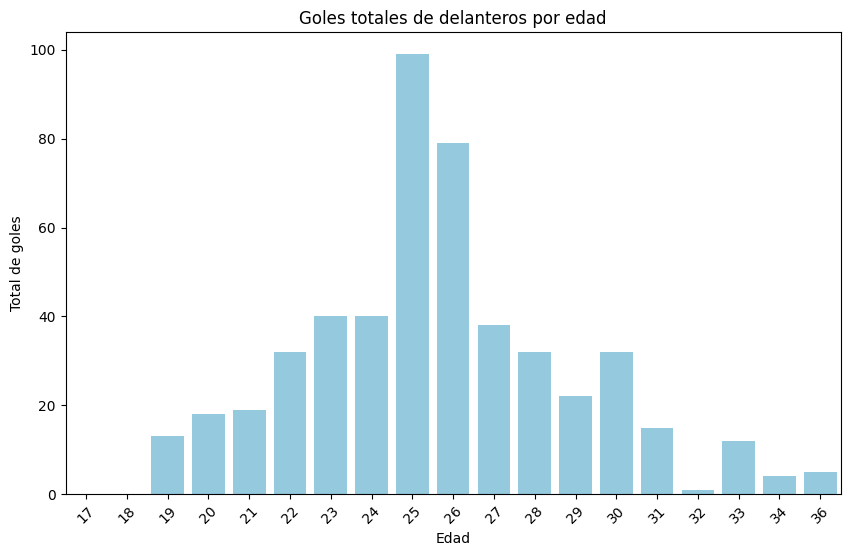

,player_name,goals,age,position
41,Mohamed Salah,32.0,25,RW
25,Harry Kane,30.0,23,CF
46,Raheem Sterling,18.0,22,LW
50,Romelu Lukaku,16.0,24,CF
2,Alexandre Lacazette,14.0,26,CF
48,Riyad Mahrez,12.0,26,RW
21,Eden Hazard,12.0,26,LW
56,Son Heung-Min,12.0,25,LW
12,Christian Eriksen,10.0,25,AM
61,Wilfried Zaha,9.0,24,RW


In [27]:
# 1. Normalizar nombres de jugadores en ambos datasets
pdf_jugadores['name_clean'] = pdf_jugadores['name'].str.lower().str.strip()
pdf_players['player_name_clean'] = pdf_players['player_name'].str.lower().str.strip()

# 2. Hacer el merge por nombre
df_merge = pd.merge(
    pdf_players,
    pdf_jugadores[['name_clean', 'age', 'position']],
    left_on='player_name_clean',
    right_on='name_clean',
    how='inner'
)

print("Coincidencias después del merge:", df_merge.shape)

# 3. Reemplazar NaN en goles por 0 (jugadores que no marcaron)
df_merge['goals'] = df_merge['goals'].fillna(0)

# 4. Revisar posiciones únicas para confirmar etiquetas
print("Posiciones disponibles:", df_merge['position'].unique())

# 5. Definir posiciones ofensivas (delanteros y mediapuntas)
posiciones_delanteros = ["FW", "ST", "CF", "LW", "RW", "AM"]

# 6. Filtrar solo delanteros
delanteros = df_merge[df_merge['position'].isin(posiciones_delanteros)]
print("Cantidad de delanteros:", delanteros.shape[0])

# Agrupar por edad exacta
goles_por_edad = delanteros.groupby("age")["goals"].sum().reset_index()

# Gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(data=goles_por_edad, x="age", y="goals", color="skyblue")
plt.title("Goles totales de delanteros por edad")
plt.xlabel("Edad")
plt.ylabel("Total de goles")
plt.xticks(rotation=45)
plt.show()

# 1. Filtrar delanteros con edad entre 22 y 27
delanteros_22_27 = delanteros[(delanteros["age"] >= 22) & (delanteros["age"] <= 27)]

# 2. Agrupar por jugador y sumar goles
ranking_goleadores = delanteros_22_27.groupby("player_name").agg({
    "goals": "sum",
    "age": "first",          # mantener edad
    "position": "first"      # mantener posición
}).reset_index()

# 3. Ordenar de mayor a menor
ranking_goleadores = ranking_goleadores.sort_values(by="goals", ascending=False)

# 4. Seleccionar Top 30
top30_goleadores = ranking_goleadores.head(30)

# 5. Mostrar tabla
top30_goleadores





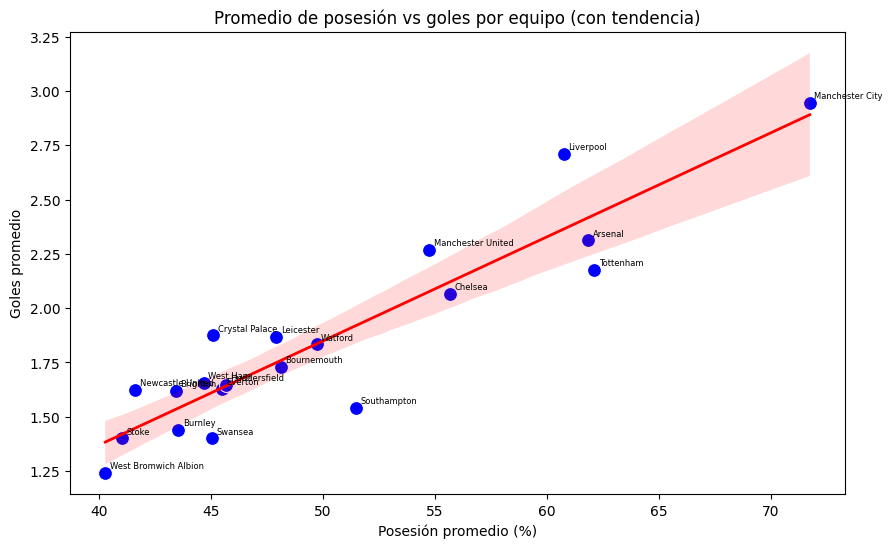

In [28]:
# Agrupar por equipo
equipos_avg = pdf_teams.groupby("team_name")[["possession_percentage","goals"]].mean().reset_index()

plt.figure(figsize=(10,6))

# Scatterplot
sns.scatterplot(data=equipos_avg, x="possession_percentage", y="goals", s=100, color="blue")

# Línea de tendencia
sns.regplot(data=equipos_avg, x="possession_percentage", y="goals",
            scatter=False, color="red", line_kws={"linewidth":2})

# Etiquetas de equipos
for i in range(equipos_avg.shape[0]):
    plt.text(equipos_avg["possession_percentage"].iloc[i] + 0.2,
             equipos_avg["goals"].iloc[i] + 0.02,
             equipos_avg["team_name"].iloc[i],
             fontsize=6)

plt.title("Promedio de posesión vs goles por equipo (con tendencia)")
plt.xlabel("Posesión promedio (%)")
plt.ylabel("Goles promedio")
plt.show()



/tmp/ipython-input-1324120396.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf_players, x="rating_group", y="ofensivo", palette="Blues")
/tmp/ipython-input-1324120396.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf_players, x="rating_group", y="defensivo", palette="Reds")


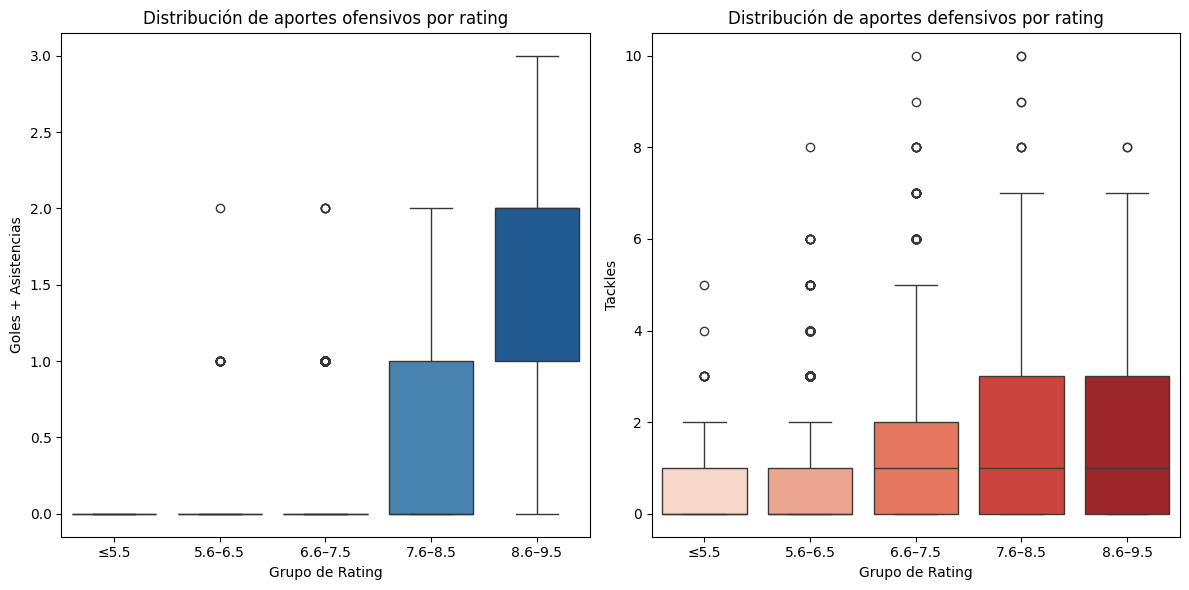

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Crear columnas ofensivo y defensivo si no existen
if "ofensivo" not in pdf_players.columns:
    pdf_players["ofensivo"] = pdf_players["goals"].fillna(0) + pdf_players["goal_assist"].fillna(0)
if "defensivo" not in pdf_players.columns:
    pdf_players["defensivo"] = pdf_players["total_tackle"].fillna(0)

# 2. Crear grupos de rating
bins = [0, 5.5, 6.5, 7.5, 8.5, 9.5]
labels = ["≤5.5", "5.6–6.5", "6.6–7.5", "7.6–8.5", "8.6–9.5"]
pdf_players["rating_group"] = pd.cut(pdf_players["player_rating"], bins=bins, labels=labels)

# 3. Boxplot ofensivo y defensivo según rating
plt.figure(figsize=(12,6))

# Ofensivo
plt.subplot(1,2,1)
sns.boxplot(data=pdf_players, x="rating_group", y="ofensivo", palette="Blues")
plt.title("Distribución de aportes ofensivos por rating")
plt.xlabel("Grupo de Rating")
plt.ylabel("Goles + Asistencias")

# Defensivo
plt.subplot(1,2,2)
sns.boxplot(data=pdf_players, x="rating_group", y="defensivo", palette="Reds")
plt.title("Distribución de aportes defensivos por rating")
plt.xlabel("Grupo de Rating")
plt.ylabel("Tackles")

plt.tight_layout()
plt.show()






In [31]:
# --- 1. Normalizar nombres en ambos datasets ---
pdf_jugadores["name_clean"] = pdf_jugadores["name"].str.lower().str.strip()
pdf_players["player_name_clean"] = pdf_players["player_name"].str.lower().str.strip()

# --- 2. Agrupar estadísticas por jugador ---
stats_por_jugador = pdf_players.groupby("player_name_clean").agg({
    "player_rating": "mean",       # rating promedio
    "goals": "sum",                # goles acumulados
    "goal_assist": "sum",          # asistencias acumuladas
    "total_tackle": "sum"          # tackles acumulados
}).reset_index()

# --- 3. Merge con dataset de jugadores (para traer club y market_value) ---
df_merge_valor = pd.merge(
    stats_por_jugador,
    pdf_jugadores[["name_clean", "name", "club", "market_value"]],
    left_on="player_name_clean",
    right_on="name_clean",
    how="inner"
)

# --- 4. Calcular polivalencia ponderada (ofensivo más pesado que defensivo) ---
df_merge_valor["polivalencia"] = (
    df_merge_valor["goals"].fillna(0) * 5 +
    df_merge_valor["goal_assist"].fillna(0) * 3 +
    df_merge_valor["total_tackle"].fillna(0) * 1
)

# --- 5. Filtrar jugadores con valor < 50 millones ---
df_merge_valor_filtrado = df_merge_valor[df_merge_valor["market_value"] < 50]

# --- 6. Seleccionar Top 20 por polivalencia ---
top20_fichajes = df_merge_valor_filtrado.sort_values(by="polivalencia", ascending=False).head(20)

# --- 7. Tabla final ---
top20_fichajes_table = top20_fichajes[
    ["name","club","player_rating","goals","goal_assist","total_tackle","market_value","polivalencia"]
].rename(columns={"name": "player_name"})

# Mostrar tabla
top20_fichajes_table








,player_name,club,player_rating,goals,goal_assist,total_tackle,market_value,polivalencia
244,Mohamed Salah,Liverpool,7.691111,32.0,10.0,12.0,35.0,202.0
281,Roberto Firmino,Liverpool,7.196842,15.0,7.0,65.0,38.0,161.0
344,Wilfred Ndidi,Leicester+City,7.145455,0.0,3.0,139.0,14.0,148.0
274,Raheem Sterling,Manchester+City,7.324706,18.0,11.0,19.0,45.0,142.0
208,Luka Milivojevic,Crystal+Palace,6.825946,10.0,1.0,85.0,10.0,138.0
2,Aaron Mooy,Huddersfield,6.868889,4.0,3.0,103.0,5.0,132.0
54,Christian Eriksen,Tottenham,7.399730,10.0,10.0,51.0,40.0,131.0
126,Idrissa Gueye,Everton,6.741471,2.0,1.0,117.0,18.0,130.0
278,Riyad Mahrez,Leicester+City,7.274167,12.0,10.0,39.0,30.0,129.0
155,Joe Allen,Stoke+City,6.685946,2.0,6.0,96.0,15.0,124.0


##**Hallazgos interesantes del problema de negocio**

##Goles de delanteros por edad

La distribución indica que los delanteros alcanzan su máximo nivel goleador alrededor de los 25–26 años, lo que coincide con la etapa de mayor madurez física y técnica en el fútbol profesional. A edades más tempranas (18–21) la producción goleadora es menor, probablemente por menor experiencia y menos minutos en cancha. Después de los 27–28 años, los goles empiezan a descender, lo que refleja una posible pérdida de velocidad o protagonismo ofensivo con el paso del tiempo.

En síntesis, los datos muestran que la edad pico de rendimiento goleador en delanteros se concentra en la mitad de la veintena, lo cual es clave para estrategias de scouting y planificación de plantillas.

##Promedio de posesíon vs Goles

El análisis evidencia una correlación positiva entre la posesión promedio y los goles anotados por equipo: aquellos clubes que controlan más el balón suelen generar y concretar más ocasiones ofensivas. Ejemplos como Manchester City, Liverpool o Arsenal confirman esta tendencia al combinar altos porcentajes de posesión con promedios de gol elevados. Asimismo, se observa que los equipos con posesión superior al 55% ganan en promedio más partidos, lo que sugiere que un estilo de juego basado en la posesión no solo incrementa la producción goleadora, sino que también se traduce en mayor éxito competitivo. Sin embargo, existen excepciones como Southampton (ineficiencia ofensiva) o Liverpool (mayor efectividad de lo esperado), lo que indica que la calidad en la ejecución táctica y la eficiencia en el ataque también juegan un rol determinante en los resultados.

##Distribucion de aportes ofensivos/defensivos y polivalencia

Los boxplots muestran que los jugadores con ratings más altos tienden a aportar más tanto en ataque (goles + asistencias) como en defensa (tackles), aunque el efecto es más marcado en los aportes ofensivos, donde el crecimiento es más evidente a medida que aumenta el grupo de rating. Esto confirma que un buen rendimiento estadístico no se limita a una sola faceta del juego, sino que suele estar asociado a una contribución equilibrada en ambas dimensiones.

Al mismo tiempo, el análisis de polivalencia ponderada permite identificar a los jugadores que, con un valor de mercado inferior a 50 millones, ofrecen el mejor balance entre producción ofensiva y defensiva. En este grupo aparecen futbolistas como Roberto Firmino, Wilfred Ndidi o Luka Milivojevic, quienes combinan distintas habilidades de manera efectiva, posicionándose como fichajes estratégicos de alto rendimiento relativo.

En conjunto, los resultados evidencian que la polivalencia, entendida como la capacidad de influir en ataque y defensa, no solo impulsa el rating individual, sino que también ofrece oportunidades de mercado al permitir detectar jugadores con gran impacto en el juego por un costo relativamente bajo.



#**Resultados**
A partir del analisis realizado encontramos que nuestro equipo debe tomar las siguientes decisiones para triunfar la proxima temporada en la premier League.

1. **Estilo de juego**
Es totalmente claro que debemos tomar un estilo de juego con alta posesion de balon. En la segunda grafica se vio totalmente evidente como estos equipos que mantienen la posesion suelen ser los que mejores resultados tienen tanto en goles anotados como en posiciones de la tabla. En esta temporada descendieron el West Bromwich, el Stoke city y el Swansea, equipos con porcentaje de posesion promedio muy bajo y que a su vez no tuvieron una efectividad de goles vs posesion superior a la media.

2. **Fichajes de delanteros**
En nuestra primera tabla pudimos concluir que los delanteros entre 22 y 27 años por lo cual debemos buscar delanteros con este perfil. A su vez, tambien encontramos que los ataques mas efectivos de la liga son los que tienen la media de goles sobre la linea de tendencia en cuanto a la posesion promedio del equipo (Manchester United, Liverpool, Leicester City, Crystal Palace, Newcastle, Brighton y West Ham)

A partir de esto pudimos encontrar que hay que apostar por una delantera conformada por Riyad Mahrez, Wilfried Zaha y Romelu Lukaku. Esto debido a que son los jugadores de esos equipos que estan dentro del rango de edad y que estan entre los maximos goleadores de la liga. Siendo jugadores muy efectivos.

Cabe destacar que se omiten jugadores como Mohamed Salah o Eden Hazard ya que son totalmente intransferibles para sus respectivos equipos, por lo cual no los lograriamos fichar por mas de que contaramos con el presupuesto.

3. **Fichajes en el mediocampo**
Para el mediocampo usamos un criterio similar, jugadores que sean parte de equipos muy efectivos (Manchester United, Liverpool, Leicester City, Crystal Palace, Newcastle, Brighton y West Ham) y por otro lado necesitamos jugadores muy polivalentes y con un buen rating promedio.

A partir de esto encontramos a Wilfried Ndidi como la base de nuestro mediocampo, un jugador totalmente polivalente y que fue parte de uno de los equipos mas efectivos la temporada pasada. El fichaje de ndidi lo complementamos con los de Luka Milivojevic y Aaron Mooy, el cual es uno de los jugadores mas polivalentes de la liga y a pesar de no ser parte de los equipos en los que nos interesa fichar es una oportunidad de mercado gigante por su bajo valor de mercado

4. **Fichajes en defensa**
En la defensa queremos buscar a los jugadores de equipos que lograron una buena posicion en la tabla a pesar de tener muy poca posesion, ya que estos son los que mas situaciones en contra suelen recibir. A partir de esto vamos a seccionar nuestra busqueda hacia los siguientes equipos: Everton, Newcastle, Leicester, Crystal Palace y West Ham.

A partir de eso seleccionamos uno de cada uno de estos equipos para armar nuestra linea defensiva y la porteria y nos fuimos por los siguientes jugadores:
Ben Chilwell en el lateral izquierdo
Jose Fonte en el central izquierdo
Michael Keane en el central derecho
Aaron Wan Bissaka en el lateral derecho
Martin Dubravka en porteria




#**Conclusiones**
- Este análisis resultó ser muy interesante porque permitió aplicar técnicas de procesamiento y visualización de datos directamente a un contexto futbolístico real, generando hallazgos que no solo enriquecen el aprendizaje académico, sino que también sirven como guía práctica para la toma de decisiones estratégicas en la conformación de un equipo competitivo.

- Este trabajo fue una experiencia muy valiosa, ya que permitió aplicar la ciencia de datos para demostrar que la analítica no solo sirve para comprender fenómenos, sino también para diseñar estrategias prácticas de scouting, fichajes y planificación táctica que podrían marcar la diferencia en una temporada competitiva.